# **Group Project 3: Airbnb Data Analytics** 

**Group Members:**
- Jesse Shen (23020703)
- Ning Jian (23019851)
- Samantha Quilat (23017224)

### Import Statements


In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import json
import re

from pylab import rcParams
rcParams['figure.figsize'] = 7, 5
rcParams['font.size'] = 10
rcParams['axes.facecolor'] = 'white'
%matplotlib inline

#Data Acquisition
import requests                 #How Python gets the webpages
from bs4 import BeautifulSoup   #Creates structured, searchable object

import os
from tabulate import tabulate
from datetime import datetime, timedelta
import time

!pip install --upgrade selenium
!pip install GeckoDriverManager
!pip install webdriver-manager
from selenium import webdriver #Provides an API for controlling web browsers programmatically.
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

!pip install urllib.parse
from urllib.parse import urlparse, parse_qs

#Methods
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

ERROR: Could not find a version that satisfies the requirement GeckoDriverManager (from versions: none)
ERROR: No matching distribution found for GeckoDriverManager


ERROR: Could not find a version that satisfies the requirement urllib.parse (from versions: none)
ERROR: No matching distribution found for urllib.parse


### Web Scraping


In [32]:
#Function to scrape availability and pricing data for a listing
def scrape_listing_pricing(listing_url, guests, num_days):
   
    #Configure Selenium options
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')  #Run Chrome in headless mode (no GUI)
    options.add_argument('--disable-gpu')  #Disable GPU acceleration
    options.add_argument('--no-sandbox')  #Bypass OS security model
    options.add_argument('--disable-dev-shm-usage')  #Overcome limited resource problems

    #Initialize ChromeDriver
    s=Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=s)

    #Open the webpage
    driver.get(listing_url) 

    #Get the current URL
    current_url = driver.current_url

    #Parse the URL
    parsed_url = urlparse(current_url)

    #Get the query parameters
    query_params = parse_qs(parsed_url.query)

    #Get the source_impression_id
    source_impression_id = query_params.get('source_impression_id', [None])[0]

    #Create a DataFrame to store the data
    df = pd.DataFrame(columns=['Check-in Date', 'Check-out Date', 'Price in NZD', 'URL'])

    start_date = datetime.now()
    current_date = start_date
    days_scraped = 0
    
    while days_scraped < num_days:
        checkin_date = current_date.strftime('%Y-%m-%d')
        checkout_date = (current_date + timedelta(days=1)).strftime('%Y-%m-%d')
        url = f"{listing_url}?check_in={checkin_date}&guests={guests}&adults={guests}&check_out={checkout_date}&source_impression_id={source_impression_id}"

        driver.get(url)
        
        try:
            WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, '_1y74zjx')))
        except Exception as e:
            current_date += timedelta(days=1)
            continue

        soup = BeautifulSoup(driver.page_source, 'html.parser')
        price_element = soup.find(class_='_1y74zjx')
        
        if price_element:
           price_text = price_element.text.strip()
           price = re.search(r'\d+', price_text).group()
           new_row = pd.DataFrame({
               'Check-in Date': [checkin_date],
               'Check-out Date': [checkout_date],
               'Price in NZD': [price],
               'URL': [url]
           })
           df = pd.concat([df, new_row], ignore_index=True)
           days_scraped += 1

        current_date += timedelta(days=1)

    driver.quit()
    return df

In [33]:
def scrape_and_save_data(listing_url, guests, num_days, filename):
    if os.path.exists(filename):
        df = pd.read_csv(filename)
        if len(df) >= num_days:
            return df.head(num_days)
    df = scrape_listing_pricing(listing_url, guests, num_days)
    df.to_csv(filename, index=False)
    return df


#### Modern Private · Albany Centre · WiFi · 2 Garage (Hosted by Jim)

In [34]:
listing_url = 'https://www.airbnb.co.nz/rooms/1125096139567330802'
guests = 3
num_days = 90 #3 Months
filename = 'jim_airbnb_data.csv'

#Scrape pricing data for the next 180 days
Jim = scrape_and_save_data(listing_url, guests, num_days, filename)
pd.set_option('display.max_colwidth', 200)
Jim

,Check-in Date,Check-out Date,Price in NZD,URL
0,2024-05-24,2024-05-25,210,https://www.airbnb.co.nz/rooms/1125096139567330802?check_in=2024-05-24&guests=3&adults=3&check_out=2024-05-25&source_impression_id=p3_1716360138_am4FZZS0vB0cllcB
1,2024-06-03,2024-06-04,177,https://www.airbnb.co.nz/rooms/1125096139567330802?check_in=2024-06-03&guests=3&adults=3&check_out=2024-06-04&source_impression_id=p3_1716360138_am4FZZS0vB0cllcB
2,2024-06-04,2024-06-05,173,https://www.airbnb.co.nz/rooms/1125096139567330802?check_in=2024-06-04&guests=3&adults=3&check_out=2024-06-05&source_impression_id=p3_1716360138_am4FZZS0vB0cllcB
3,2024-06-05,2024-06-06,170,https://www.airbnb.co.nz/rooms/1125096139567330802?check_in=2024-06-05&guests=3&adults=3&check_out=2024-06-06&source_impression_id=p3_1716360138_am4FZZS0vB0cllcB
4,2024-06-06,2024-06-07,170,https://www.airbnb.co.nz/rooms/1125096139567330802?check_in=2024-06-06&guests=3&adults=3&check_out=2024-06-07&source_impression_id=p3_1716360138_am4FZZS0vB0cllcB
...,...,...,...,...
85,2024-11-25,2024-11-26,252,https://www.airbnb.co.nz/rooms/1125096139567330802?check_in=2024-11-25&guests=3&adults=3&check_out=2024-11-26&source_impression_id=p3_1716360138_am4FZZS0vB0cllcB
86,2024-11-26,2024-11-27,253,https://www.airbnb.co.nz/rooms/1125096139567330802?check_in=2024-11-26&guests=3&adults=3&check_out=2024-11-27&source_impression_id=p3_1716360138_am4FZZS0vB0cllcB
87,2024-11-27,2024-11-28,255,https://www.airbnb.co.nz/rooms/1125096139567330802?check_in=2024-11-27&guests=3&adults=3&check_out=2024-11-28&source_impression_id=p3_1716360138_am4FZZS0vB0cllcB
88,2024-11-28,2024-11-29,257,https://www.airbnb.co.nz/rooms/1125096139567330802?check_in=2024-11-28&guests=3&adults=3&check_out=2024-11-29&source_impression_id=p3_1716360138_am4FZZS0vB0cllcB


#### Modern Private Home, Full kitchen with 2bathroom (Hosted by Alex)

In [35]:
#Example URL and parameters
listing_url = 'https://www.airbnb.co.nz/rooms/49525122'
guests = 3
num_days = 90 #3 Months
filename = 'alexa_airbnb_data.csv'

#Scrape pricing data for the next 180 days
Alex = scrape_and_save_data(listing_url, guests, num_days, filename)
pd.set_option('display.max_colwidth', 200)
Alex

,Check-in Date,Check-out Date,Price in NZD,URL
0,2024-05-24,2024-05-25,172,https://www.airbnb.co.nz/rooms/49525122?check_in=2024-05-24&guests=3&adults=3&check_out=2024-05-25&source_impression_id=p3_1716361500_bAclQ5Og9oNC+KqO
1,2024-05-25,2024-05-26,172,https://www.airbnb.co.nz/rooms/49525122?check_in=2024-05-25&guests=3&adults=3&check_out=2024-05-26&source_impression_id=p3_1716361500_bAclQ5Og9oNC+KqO
2,2024-05-26,2024-05-27,172,https://www.airbnb.co.nz/rooms/49525122?check_in=2024-05-26&guests=3&adults=3&check_out=2024-05-27&source_impression_id=p3_1716361500_bAclQ5Og9oNC+KqO
3,2024-05-27,2024-05-28,172,https://www.airbnb.co.nz/rooms/49525122?check_in=2024-05-27&guests=3&adults=3&check_out=2024-05-28&source_impression_id=p3_1716361500_bAclQ5Og9oNC+KqO
4,2024-05-28,2024-05-29,172,https://www.airbnb.co.nz/rooms/49525122?check_in=2024-05-28&guests=3&adults=3&check_out=2024-05-29&source_impression_id=p3_1716361500_bAclQ5Og9oNC+KqO
...,...,...,...,...
85,2024-10-01,2024-10-02,218,https://www.airbnb.co.nz/rooms/49525122?check_in=2024-10-01&guests=3&adults=3&check_out=2024-10-02&source_impression_id=p3_1716361500_bAclQ5Og9oNC+KqO
86,2024-10-02,2024-10-03,218,https://www.airbnb.co.nz/rooms/49525122?check_in=2024-10-02&guests=3&adults=3&check_out=2024-10-03&source_impression_id=p3_1716361500_bAclQ5Og9oNC+KqO
87,2024-10-03,2024-10-04,218,https://www.airbnb.co.nz/rooms/49525122?check_in=2024-10-03&guests=3&adults=3&check_out=2024-10-04&source_impression_id=p3_1716361500_bAclQ5Og9oNC+KqO
88,2024-10-04,2024-10-05,218,https://www.airbnb.co.nz/rooms/49525122?check_in=2024-10-04&guests=3&adults=3&check_out=2024-10-05&source_impression_id=p3_1716361500_bAclQ5Og9oNC+KqO


#### Sleek Urban Oasis In Albany (Hosted by Glenda)

In [36]:
listing_url = 'https://www.airbnb.co.nz/rooms/1044551981539410265'
guests = 3
num_days = 90 #3 Months
filename = 'glenda_airbnb_data.csv'

#Scrape pricing data for the next 180 days
Glenda = scrape_and_save_data(listing_url, guests, num_days, filename)
pd.set_option('display.max_colwidth', 200)
Glenda

,Check-in Date,Check-out Date,Price in NZD,URL
0,2024-05-22,2024-05-23,313,https://www.airbnb.co.nz/rooms/1044551981539410265?check_in=2024-05-22&guests=3&adults=3&check_out=2024-05-23&source_impression_id=p3_1716362252_GHHtDuwpp0EwNwIK
1,2024-05-23,2024-05-24,313,https://www.airbnb.co.nz/rooms/1044551981539410265?check_in=2024-05-23&guests=3&adults=3&check_out=2024-05-24&source_impression_id=p3_1716362252_GHHtDuwpp0EwNwIK
2,2024-05-25,2024-05-26,313,https://www.airbnb.co.nz/rooms/1044551981539410265?check_in=2024-05-25&guests=3&adults=3&check_out=2024-05-26&source_impression_id=p3_1716362252_GHHtDuwpp0EwNwIK
3,2024-05-26,2024-05-27,313,https://www.airbnb.co.nz/rooms/1044551981539410265?check_in=2024-05-26&guests=3&adults=3&check_out=2024-05-27&source_impression_id=p3_1716362252_GHHtDuwpp0EwNwIK
4,2024-05-27,2024-05-28,313,https://www.airbnb.co.nz/rooms/1044551981539410265?check_in=2024-05-27&guests=3&adults=3&check_out=2024-05-28&source_impression_id=p3_1716362252_GHHtDuwpp0EwNwIK
...,...,...,...,...
85,2024-09-13,2024-09-14,313,https://www.airbnb.co.nz/rooms/1044551981539410265?check_in=2024-09-13&guests=3&adults=3&check_out=2024-09-14&source_impression_id=p3_1716362252_GHHtDuwpp0EwNwIK
86,2024-09-14,2024-09-15,313,https://www.airbnb.co.nz/rooms/1044551981539410265?check_in=2024-09-14&guests=3&adults=3&check_out=2024-09-15&source_impression_id=p3_1716362252_GHHtDuwpp0EwNwIK
87,2024-09-15,2024-09-16,313,https://www.airbnb.co.nz/rooms/1044551981539410265?check_in=2024-09-15&guests=3&adults=3&check_out=2024-09-16&source_impression_id=p3_1716362252_GHHtDuwpp0EwNwIK
88,2024-09-16,2024-09-17,313,https://www.airbnb.co.nz/rooms/1044551981539410265?check_in=2024-09-16&guests=3&adults=3&check_out=2024-09-17&source_impression_id=p3_1716362252_GHHtDuwpp0EwNwIK


#### Luxury 2 BDR apartment w/ designer interior (Hosted by Joshua)

In [37]:
listing_url = 'https://www.airbnb.co.nz/rooms/566193144075100847'
guests = 3
num_days = 90 #3 Months
filename = 'joshua_airbnb_data.csv'

#Scrape pricing data for the next 180 days
Joshua = scrape_and_save_data(listing_url, guests, num_days, filename)
pd.set_option('display.max_colwidth', 200)
Joshua

,Check-in Date,Check-out Date,Price in NZD,URL
0,2024-05-23,2024-05-24,156,https://www.airbnb.co.nz/rooms/566193144075100847?check_in=2024-05-23&guests=3&adults=3&check_out=2024-05-24&source_impression_id=p3_1716362788_yutiCjLckrZhwp7u
1,2024-05-24,2024-05-25,188,https://www.airbnb.co.nz/rooms/566193144075100847?check_in=2024-05-24&guests=3&adults=3&check_out=2024-05-25&source_impression_id=p3_1716362788_yutiCjLckrZhwp7u
2,2024-05-25,2024-05-26,188,https://www.airbnb.co.nz/rooms/566193144075100847?check_in=2024-05-25&guests=3&adults=3&check_out=2024-05-26&source_impression_id=p3_1716362788_yutiCjLckrZhwp7u
3,2024-05-26,2024-05-27,188,https://www.airbnb.co.nz/rooms/566193144075100847?check_in=2024-05-26&guests=3&adults=3&check_out=2024-05-27&source_impression_id=p3_1716362788_yutiCjLckrZhwp7u
4,2024-05-27,2024-05-28,235,https://www.airbnb.co.nz/rooms/566193144075100847?check_in=2024-05-27&guests=3&adults=3&check_out=2024-05-28&source_impression_id=p3_1716362788_yutiCjLckrZhwp7u
...,...,...,...,...
85,2024-08-18,2024-08-19,410,https://www.airbnb.co.nz/rooms/566193144075100847?check_in=2024-08-18&guests=3&adults=3&check_out=2024-08-19&source_impression_id=p3_1716362788_yutiCjLckrZhwp7u
86,2024-08-19,2024-08-20,410,https://www.airbnb.co.nz/rooms/566193144075100847?check_in=2024-08-19&guests=3&adults=3&check_out=2024-08-20&source_impression_id=p3_1716362788_yutiCjLckrZhwp7u
87,2024-08-20,2024-08-21,410,https://www.airbnb.co.nz/rooms/566193144075100847?check_in=2024-08-20&guests=3&adults=3&check_out=2024-08-21&source_impression_id=p3_1716362788_yutiCjLckrZhwp7u
88,2024-08-21,2024-08-22,410,https://www.airbnb.co.nz/rooms/566193144075100847?check_in=2024-08-21&guests=3&adults=3&check_out=2024-08-22&source_impression_id=p3_1716362788_yutiCjLckrZhwp7u


#### 7 mins drive to Albany Centre, Private & elegant (Hosted by Prince)

In [38]:
listing_url = 'https://www.airbnb.co.nz/rooms/1115473858923244250'
guests = 3
num_days = 90 #3 Months
filename = 'prince_airbnb_data.csv'

#Scrape pricing data for the next 180 days
Prince = scrape_and_save_data(listing_url, guests, num_days, filename)
pd.set_option('display.max_colwidth', 200)
Prince

,Check-in Date,Check-out Date,Price in NZD,URL
0,2024-05-22,2024-05-23,210,https://www.airbnb.co.nz/rooms/1115473858923244250?check_in=2024-05-22&guests=3&adults=3&check_out=2024-05-23&source_impression_id=p3_1716369803_UkzPMdTCxSJ6iuH3
1,2024-05-23,2024-05-24,210,https://www.airbnb.co.nz/rooms/1115473858923244250?check_in=2024-05-23&guests=3&adults=3&check_out=2024-05-24&source_impression_id=p3_1716369803_UkzPMdTCxSJ6iuH3
2,2024-05-27,2024-05-28,210,https://www.airbnb.co.nz/rooms/1115473858923244250?check_in=2024-05-27&guests=3&adults=3&check_out=2024-05-28&source_impression_id=p3_1716369803_UkzPMdTCxSJ6iuH3
3,2024-05-28,2024-05-29,210,https://www.airbnb.co.nz/rooms/1115473858923244250?check_in=2024-05-28&guests=3&adults=3&check_out=2024-05-29&source_impression_id=p3_1716369803_UkzPMdTCxSJ6iuH3
4,2024-05-29,2024-05-30,210,https://www.airbnb.co.nz/rooms/1115473858923244250?check_in=2024-05-29&guests=3&adults=3&check_out=2024-05-30&source_impression_id=p3_1716369803_UkzPMdTCxSJ6iuH3
...,...,...,...,...
85,2024-08-20,2024-08-21,235,https://www.airbnb.co.nz/rooms/1115473858923244250?check_in=2024-08-20&guests=3&adults=3&check_out=2024-08-21&source_impression_id=p3_1716369803_UkzPMdTCxSJ6iuH3
86,2024-08-21,2024-08-22,235,https://www.airbnb.co.nz/rooms/1115473858923244250?check_in=2024-08-21&guests=3&adults=3&check_out=2024-08-22&source_impression_id=p3_1716369803_UkzPMdTCxSJ6iuH3
87,2024-08-22,2024-08-23,235,https://www.airbnb.co.nz/rooms/1115473858923244250?check_in=2024-08-22&guests=3&adults=3&check_out=2024-08-23&source_impression_id=p3_1716369803_UkzPMdTCxSJ6iuH3
88,2024-08-23,2024-08-24,235,https://www.airbnb.co.nz/rooms/1115473858923244250?check_in=2024-08-23&guests=3&adults=3&check_out=2024-08-24&source_impression_id=p3_1716369803_UkzPMdTCxSJ6iuH3


#### Pinehill 2 Bedroom Unit (Hosted by Tiffany)

In [39]:
listing_url = 'https://www.airbnb.co.nz/rooms/1017748763616316098'
guests = 3
num_days = 90 #3 Months
filename = 'tiffany_airbnb_data.csv'

#Scrape pricing data for the next 180 days
Tiffany = scrape_and_save_data(listing_url, guests, num_days, filename)
pd.set_option('display.max_colwidth', 200)
Tiffany

,Check-in Date,Check-out Date,Price in NZD,URL
0,2024-05-31,2024-06-01,236,https://www.airbnb.co.nz/rooms/1017748763616316098?check_in=2024-05-31&guests=3&adults=3&check_out=2024-06-01&source_impression_id=p3_1716370038_pqdFThnXtIHe9zJt
1,2024-06-01,2024-06-02,258,https://www.airbnb.co.nz/rooms/1017748763616316098?check_in=2024-06-01&guests=3&adults=3&check_out=2024-06-02&source_impression_id=p3_1716370038_pqdFThnXtIHe9zJt
2,2024-06-02,2024-06-03,258,https://www.airbnb.co.nz/rooms/1017748763616316098?check_in=2024-06-02&guests=3&adults=3&check_out=2024-06-03&source_impression_id=p3_1716370038_pqdFThnXtIHe9zJt
3,2024-06-03,2024-06-04,258,https://www.airbnb.co.nz/rooms/1017748763616316098?check_in=2024-06-03&guests=3&adults=3&check_out=2024-06-04&source_impression_id=p3_1716370038_pqdFThnXtIHe9zJt
4,2024-06-04,2024-06-05,258,https://www.airbnb.co.nz/rooms/1017748763616316098?check_in=2024-06-04&guests=3&adults=3&check_out=2024-06-05&source_impression_id=p3_1716370038_pqdFThnXtIHe9zJt
...,...,...,...,...
85,2024-09-08,2024-09-09,262,https://www.airbnb.co.nz/rooms/1017748763616316098?check_in=2024-09-08&guests=3&adults=3&check_out=2024-09-09&source_impression_id=p3_1716370038_pqdFThnXtIHe9zJt
86,2024-09-09,2024-09-10,262,https://www.airbnb.co.nz/rooms/1017748763616316098?check_in=2024-09-09&guests=3&adults=3&check_out=2024-09-10&source_impression_id=p3_1716370038_pqdFThnXtIHe9zJt
87,2024-09-10,2024-09-11,262,https://www.airbnb.co.nz/rooms/1017748763616316098?check_in=2024-09-10&guests=3&adults=3&check_out=2024-09-11&source_impression_id=p3_1716370038_pqdFThnXtIHe9zJt
88,2024-09-11,2024-09-12,262,https://www.airbnb.co.nz/rooms/1017748763616316098?check_in=2024-09-11&guests=3&adults=3&check_out=2024-09-12&source_impression_id=p3_1716370038_pqdFThnXtIHe9zJt


#### Luxury brand new house with free parking (Hosted by Michael)

In [40]:
listing_url = 'https://www.airbnb.co.nz/rooms/1008128615688965304'
guests = 3
num_days = 90 #3 Months
filename = 'michael_airbnb_data.csv'

#Scrape pricing data for the next 180 days
Michael = scrape_and_save_data(listing_url, guests, num_days, filename)
pd.set_option('display.max_colwidth', 200)
Michael

,Check-in Date,Check-out Date,Price in NZD,URL
0,2024-05-27,2024-05-28,141,https://www.airbnb.co.nz/rooms/1008128615688965304?check_in=2024-05-27&guests=3&adults=3&check_out=2024-05-28&source_impression_id=p3_1716370492_ruvZ+Rd7L31+3RPB
1,2024-05-28,2024-05-29,141,https://www.airbnb.co.nz/rooms/1008128615688965304?check_in=2024-05-28&guests=3&adults=3&check_out=2024-05-29&source_impression_id=p3_1716370492_ruvZ+Rd7L31+3RPB
2,2024-05-29,2024-05-30,141,https://www.airbnb.co.nz/rooms/1008128615688965304?check_in=2024-05-29&guests=3&adults=3&check_out=2024-05-30&source_impression_id=p3_1716370492_ruvZ+Rd7L31+3RPB
3,2024-05-30,2024-05-31,141,https://www.airbnb.co.nz/rooms/1008128615688965304?check_in=2024-05-30&guests=3&adults=3&check_out=2024-05-31&source_impression_id=p3_1716370492_ruvZ+Rd7L31+3RPB
4,2024-06-03,2024-06-04,178,https://www.airbnb.co.nz/rooms/1008128615688965304?check_in=2024-06-03&guests=3&adults=3&check_out=2024-06-04&source_impression_id=p3_1716370492_ruvZ+Rd7L31+3RPB
...,...,...,...,...
85,2024-10-02,2024-10-03,271,https://www.airbnb.co.nz/rooms/1008128615688965304?check_in=2024-10-02&guests=3&adults=3&check_out=2024-10-03&source_impression_id=p3_1716370492_ruvZ+Rd7L31+3RPB
86,2024-10-03,2024-10-04,271,https://www.airbnb.co.nz/rooms/1008128615688965304?check_in=2024-10-03&guests=3&adults=3&check_out=2024-10-04&source_impression_id=p3_1716370492_ruvZ+Rd7L31+3RPB
87,2024-10-04,2024-10-05,271,https://www.airbnb.co.nz/rooms/1008128615688965304?check_in=2024-10-04&guests=3&adults=3&check_out=2024-10-05&source_impression_id=p3_1716370492_ruvZ+Rd7L31+3RPB
88,2024-10-05,2024-10-06,271,https://www.airbnb.co.nz/rooms/1008128615688965304?check_in=2024-10-05&guests=3&adults=3&check_out=2024-10-06&source_impression_id=p3_1716370492_ruvZ+Rd7L31+3RPB


#### Delightful Double Bedroom Unit (Hosted by Noorani)

In [42]:
listing_url = 'https://www.airbnb.co.nz/rooms/698990872569498801'
guests = 3
num_days = 90 #3 Months
filename = 'noorani_airbnb_data.csv'

#Scrape pricing data for the next 180 days
Noorani = scrape_and_save_data(listing_url, guests, num_days, filename)
pd.set_option('display.max_colwidth', 200)
Noorani

,Check-in Date,Check-out Date,Price in NZD,URL
0,2024-05-22,2024-05-23,133,https://www.airbnb.co.nz/rooms/698990872569498801?check_in=2024-05-22&guests=3&adults=3&check_out=2024-05-23&source_impression_id=p3_1716374452_Wv/Z9EAbGc0vtfJu
1,2024-05-23,2024-05-24,133,https://www.airbnb.co.nz/rooms/698990872569498801?check_in=2024-05-23&guests=3&adults=3&check_out=2024-05-24&source_impression_id=p3_1716374452_Wv/Z9EAbGc0vtfJu
2,2024-05-24,2024-05-25,133,https://www.airbnb.co.nz/rooms/698990872569498801?check_in=2024-05-24&guests=3&adults=3&check_out=2024-05-25&source_impression_id=p3_1716374452_Wv/Z9EAbGc0vtfJu
3,2024-05-30,2024-05-31,139,https://www.airbnb.co.nz/rooms/698990872569498801?check_in=2024-05-30&guests=3&adults=3&check_out=2024-05-31&source_impression_id=p3_1716374452_Wv/Z9EAbGc0vtfJu
4,2024-05-31,2024-06-01,150,https://www.airbnb.co.nz/rooms/698990872569498801?check_in=2024-05-31&guests=3&adults=3&check_out=2024-06-01&source_impression_id=p3_1716374452_Wv/Z9EAbGc0vtfJu
...,...,...,...,...
85,2024-08-22,2024-08-23,197,https://www.airbnb.co.nz/rooms/698990872569498801?check_in=2024-08-22&guests=3&adults=3&check_out=2024-08-23&source_impression_id=p3_1716374452_Wv/Z9EAbGc0vtfJu
86,2024-08-23,2024-08-24,201,https://www.airbnb.co.nz/rooms/698990872569498801?check_in=2024-08-23&guests=3&adults=3&check_out=2024-08-24&source_impression_id=p3_1716374452_Wv/Z9EAbGc0vtfJu
87,2024-08-24,2024-08-25,197,https://www.airbnb.co.nz/rooms/698990872569498801?check_in=2024-08-24&guests=3&adults=3&check_out=2024-08-25&source_impression_id=p3_1716374452_Wv/Z9EAbGc0vtfJu
88,2024-08-25,2024-08-26,197,https://www.airbnb.co.nz/rooms/698990872569498801?check_in=2024-08-25&guests=3&adults=3&check_out=2024-08-26&source_impression_id=p3_1716374452_Wv/Z9EAbGc0vtfJu


#### Top Schoolzone+Top Golf+Top Location - By the Bay! (Hosted by Andy)

In [44]:
listing_url = 'https://www.airbnb.co.nz/rooms/1141075033936083504'
guests = 3
num_days = 90 #3 Months
filename = 'andy_airbnb_data.csv'

#Scrape pricing data for the next 180 days
Andy = scrape_and_save_data(listing_url, guests, num_days, filename)
pd.set_option('display.max_colwidth', 200)
Andy

,Check-in Date,Check-out Date,Price in NZD,URL
0,2024-05-22,2024-05-23,193,https://www.airbnb.co.nz/rooms/1141075033936083504?check_in=2024-05-22&guests=3&adults=3&check_out=2024-05-23&source_impression_id=p3_1716375187_DzCQ/fil4FkTfY2q
1,2024-05-26,2024-05-27,193,https://www.airbnb.co.nz/rooms/1141075033936083504?check_in=2024-05-26&guests=3&adults=3&check_out=2024-05-27&source_impression_id=p3_1716375187_DzCQ/fil4FkTfY2q
2,2024-05-27,2024-05-28,193,https://www.airbnb.co.nz/rooms/1141075033936083504?check_in=2024-05-27&guests=3&adults=3&check_out=2024-05-28&source_impression_id=p3_1716375187_DzCQ/fil4FkTfY2q
3,2024-05-28,2024-05-29,193,https://www.airbnb.co.nz/rooms/1141075033936083504?check_in=2024-05-28&guests=3&adults=3&check_out=2024-05-29&source_impression_id=p3_1716375187_DzCQ/fil4FkTfY2q
4,2024-05-29,2024-05-30,193,https://www.airbnb.co.nz/rooms/1141075033936083504?check_in=2024-05-29&guests=3&adults=3&check_out=2024-05-30&source_impression_id=p3_1716375187_DzCQ/fil4FkTfY2q
...,...,...,...,...
85,2024-10-01,2024-10-02,245,https://www.airbnb.co.nz/rooms/1141075033936083504?check_in=2024-10-01&guests=3&adults=3&check_out=2024-10-02&source_impression_id=p3_1716375187_DzCQ/fil4FkTfY2q
86,2024-10-02,2024-10-03,245,https://www.airbnb.co.nz/rooms/1141075033936083504?check_in=2024-10-02&guests=3&adults=3&check_out=2024-10-03&source_impression_id=p3_1716375187_DzCQ/fil4FkTfY2q
87,2024-10-03,2024-10-04,245,https://www.airbnb.co.nz/rooms/1141075033936083504?check_in=2024-10-03&guests=3&adults=3&check_out=2024-10-04&source_impression_id=p3_1716375187_DzCQ/fil4FkTfY2q
88,2024-10-06,2024-10-07,245,https://www.airbnb.co.nz/rooms/1141075033936083504?check_in=2024-10-06&guests=3&adults=3&check_out=2024-10-07&source_impression_id=p3_1716375187_DzCQ/fil4FkTfY2q


#### Harbour View Guesthouse (Hosted by Donghong)

In [45]:
listing_url = 'https://www.airbnb.co.nz/rooms/31574846'
guests = 3
num_days = 90 #3 Months
filename = 'donghong_airbnb_data.csv'

#Scrape pricing data for the next 180 days
Donghong = scrape_and_save_data(listing_url, guests, num_days, filename)
pd.set_option('display.max_colwidth', 200)
Donghong

,Check-in Date,Check-out Date,Price in NZD,URL
0,2024-05-23,2024-05-24,199,https://www.airbnb.co.nz/rooms/31574846?check_in=2024-05-23&guests=3&adults=3&check_out=2024-05-24&source_impression_id=p3_1716375950_nyvNahiRAFq7eyNG
1,2024-05-24,2024-05-25,199,https://www.airbnb.co.nz/rooms/31574846?check_in=2024-05-24&guests=3&adults=3&check_out=2024-05-25&source_impression_id=p3_1716375950_nyvNahiRAFq7eyNG
2,2024-05-25,2024-05-26,199,https://www.airbnb.co.nz/rooms/31574846?check_in=2024-05-25&guests=3&adults=3&check_out=2024-05-26&source_impression_id=p3_1716375950_nyvNahiRAFq7eyNG
3,2024-05-26,2024-05-27,199,https://www.airbnb.co.nz/rooms/31574846?check_in=2024-05-26&guests=3&adults=3&check_out=2024-05-27&source_impression_id=p3_1716375950_nyvNahiRAFq7eyNG
4,2024-05-27,2024-05-28,199,https://www.airbnb.co.nz/rooms/31574846?check_in=2024-05-27&guests=3&adults=3&check_out=2024-05-28&source_impression_id=p3_1716375950_nyvNahiRAFq7eyNG
...,...,...,...,...
85,2024-08-16,2024-08-17,199,https://www.airbnb.co.nz/rooms/31574846?check_in=2024-08-16&guests=3&adults=3&check_out=2024-08-17&source_impression_id=p3_1716375950_nyvNahiRAFq7eyNG
86,2024-08-17,2024-08-18,199,https://www.airbnb.co.nz/rooms/31574846?check_in=2024-08-17&guests=3&adults=3&check_out=2024-08-18&source_impression_id=p3_1716375950_nyvNahiRAFq7eyNG
87,2024-08-18,2024-08-19,199,https://www.airbnb.co.nz/rooms/31574846?check_in=2024-08-18&guests=3&adults=3&check_out=2024-08-19&source_impression_id=p3_1716375950_nyvNahiRAFq7eyNG
88,2024-08-19,2024-08-20,199,https://www.airbnb.co.nz/rooms/31574846?check_in=2024-08-19&guests=3&adults=3&check_out=2024-08-20&source_impression_id=p3_1716375950_nyvNahiRAFq7eyNG


### Methods


#### Merging AirBnB Data

In [46]:
Jim.columns = ['Jim Check-in Date', 'Jim Check-out Date', 'Jim Price in NZD', 'URL']
Alex.columns = ['Alex Check-in Date', 'Alex Check-out Date', 'Alex Price in NZD', 'URL']
Glenda.columns = ['Glenda Check-in Date', 'Glenda Check-out Date', 'Glenda Price in NZD', 'URL']
Joshua.columns = ['Joshua Check-in Date', 'Joshua Check-out Date', 'Joshua Price in NZD', 'URL']
Prince.columns = ['Prince Check-in Date', 'Prince Check-out Date', 'Prince Price in NZD', 'URL']
Tiffany.columns = ['Tiffany Check-in Date', 'Tiffany Check-out Date', 'Tiffany Price in NZD', 'URL']
Michael.columns = ['Michael Check-in Date', 'Michael Check-out Date', 'Michael Price in NZD', 'URL']
Noorani.columns = ['Noorani Check-in Date', 'Noorani Check-out Date', 'Noorani Price in NZD', 'URL']
Andy.columns = ['Andy Check-in Date', 'Andy Check-out Date', 'Andy Price in NZD', 'URL']
Donghong.columns = ['Donghong Check-in Date', 'Donghong Check-out Date', 'Donghong Price in NZD', 'URL']

Airbnb = pd.concat([Jim, Alex, Glenda, Joshua, Prince, Tiffany, Michael, Noorani, Andy, Donghong], axis=1)

Airbnb = Airbnb.drop(columns=[col for col in Airbnb.columns if 'URL' in col]) #Drops URL column

names = sorted(set(col.split()[0] for col in Airbnb.columns))

#Adjust column names to match the desired format
new_columns = []
for name in names:
    new_columns.extend([f"{name} Check-in Date", f"{name} Check-out Date", f"{name} Price in NZD"])

#Reorder the columns
Airbnb = Airbnb[new_columns]

#Fill NaN values with 0
AirbnbData = Airbnb.fillna(0)
AirbnbData

,Alex Check-in Date,Alex Check-out Date,Alex Price in NZD,Andy Check-in Date,Andy Check-out Date,Andy Price in NZD,Donghong Check-in Date,Donghong Check-out Date,Donghong Price in NZD,Glenda Check-in Date,...,Michael Price in NZD,Noorani Check-in Date,Noorani Check-out Date,Noorani Price in NZD,Prince Check-in Date,Prince Check-out Date,Prince Price in NZD,Tiffany Check-in Date,Tiffany Check-out Date,Tiffany Price in NZD
0,2024-05-24,2024-05-25,172,2024-05-22,2024-05-23,193,2024-05-23,2024-05-24,199,2024-05-22,...,141,2024-05-22,2024-05-23,133,2024-05-22,2024-05-23,210,2024-05-31,2024-06-01,236
1,2024-05-25,2024-05-26,172,2024-05-26,2024-05-27,193,2024-05-24,2024-05-25,199,2024-05-23,...,141,2024-05-23,2024-05-24,133,2024-05-23,2024-05-24,210,2024-06-01,2024-06-02,258
2,2024-05-26,2024-05-27,172,2024-05-27,2024-05-28,193,2024-05-25,2024-05-26,199,2024-05-25,...,141,2024-05-24,2024-05-25,133,2024-05-27,2024-05-28,210,2024-06-02,2024-06-03,258
3,2024-05-27,2024-05-28,172,2024-05-28,2024-05-29,193,2024-05-26,2024-05-27,199,2024-05-26,...,141,2024-05-30,2024-05-31,139,2024-05-28,2024-05-29,210,2024-06-03,2024-06-04,258
4,2024-05-28,2024-05-29,172,2024-05-29,2024-05-30,193,2024-05-27,2024-05-28,199,2024-05-27,...,178,2024-05-31,2024-06-01,150,2024-05-29,2024-05-30,210,2024-06-04,2024-06-05,258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2024-10-01,2024-10-02,218,2024-10-01,2024-10-02,245,2024-08-16,2024-08-17,199,2024-09-13,...,271,2024-08-22,2024-08-23,197,2024-08-20,2024-08-21,235,2024-09-08,2024-09-09,262
86,2024-10-02,2024-10-03,218,2024-10-02,2024-10-03,245,2024-08-17,2024-08-18,199,2024-09-14,...,271,2024-08-23,2024-08-24,201,2024-08-21,2024-08-22,235,2024-09-09,2024-09-10,262
87,2024-10-03,2024-10-04,218,2024-10-03,2024-10-04,245,2024-08-18,2024-08-19,199,2024-09-15,...,271,2024-08-24,2024-08-25,197,2024-08-22,2024-08-23,235,2024-09-10,2024-09-11,262
88,2024-10-04,2024-10-05,218,2024-10-06,2024-10-07,245,2024-08-19,2024-08-20,199,2024-09-16,...,271,2024-08-25,2024-08-26,197,2024-08-23,2024-08-24,235,2024-09-11,2024-09-12,262


#### Scatter Plots

##### Jim & Alex

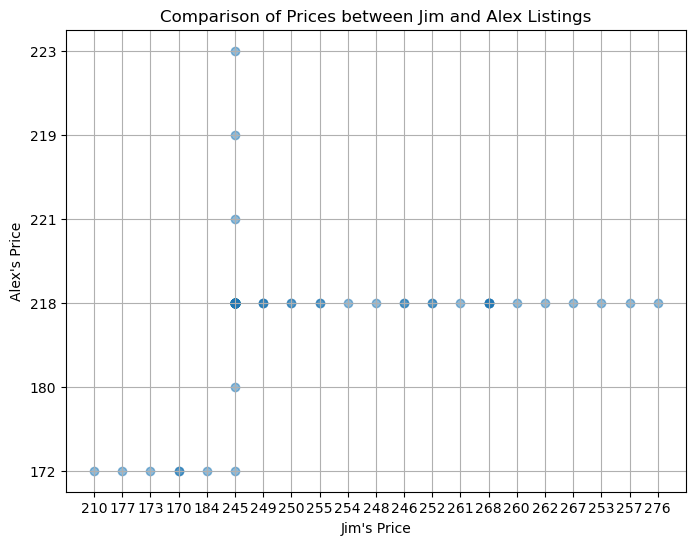

In [47]:
x_column = 'Jim Price in NZD'
y_column = 'Alex Price in NZD'

AirbnbData[x_column] = AirbnbData[x_column].astype(str)
AirbnbData[y_column] = AirbnbData[y_column].astype(str)

plt.figure(figsize=(8, 6))
plt.scatter(AirbnbData[x_column], AirbnbData[y_column], alpha=0.5)
plt.title(f'Comparison of Prices between Jim and Alex Listings')
plt.xlabel("Jim's Price")
plt.ylabel("Alex's Price")
plt.grid(True)
plt.show()

##### Jim & Glenda

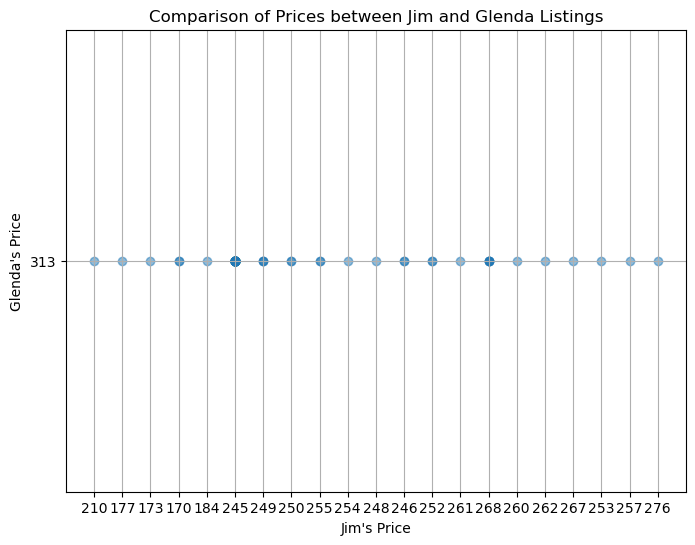

In [48]:
x_column = 'Jim Price in NZD'
y_column = 'Glenda Price in NZD'

AirbnbData[x_column] = AirbnbData[x_column].astype(str)
AirbnbData[y_column] = AirbnbData[y_column].astype(str)

plt.figure(figsize=(8, 6))
plt.scatter(AirbnbData[x_column], AirbnbData[y_column], alpha=0.5)
plt.title(f'Comparison of Prices between Jim and Glenda Listings')
plt.xlabel("Jim's Price")
plt.ylabel("Glenda's Price")
plt.grid(True)
plt.show()

##### Jim & Joshua

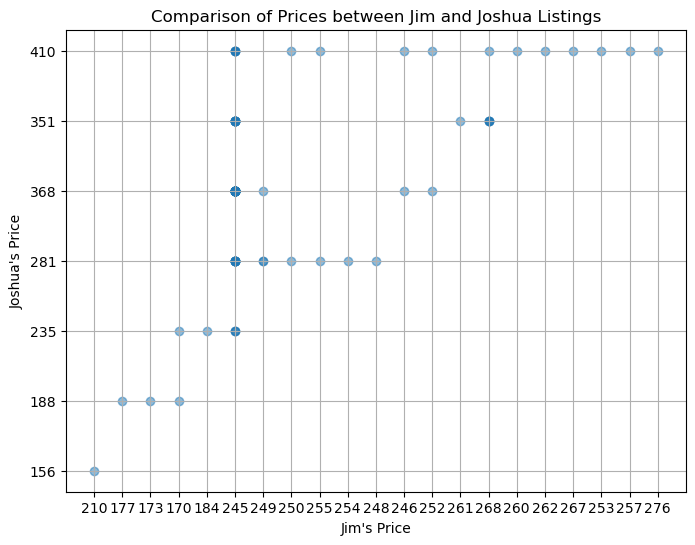

In [49]:
x_column = 'Jim Price in NZD'
y_column = 'Joshua Price in NZD'

AirbnbData[x_column] = AirbnbData[x_column].astype(str)
AirbnbData[y_column] = AirbnbData[y_column].astype(str)

plt.figure(figsize=(8, 6))
plt.scatter(AirbnbData[x_column], AirbnbData[y_column], alpha=0.5)
plt.title(f'Comparison of Prices between Jim and Joshua Listings')
plt.xlabel("Jim's Price")
plt.ylabel("Joshua's Price")
plt.grid(True)
plt.show()

##### Jim & Prince

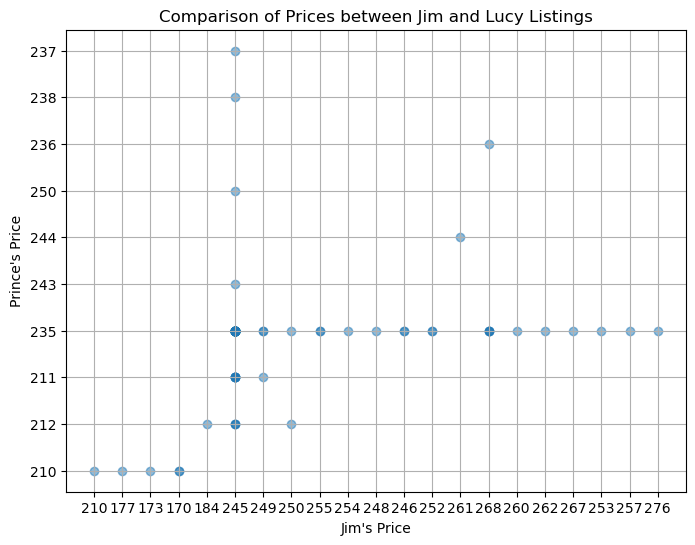

In [50]:
x_column = 'Jim Price in NZD'
y_column = 'Prince Price in NZD'

AirbnbData[x_column] = AirbnbData[x_column].astype(str)
AirbnbData[y_column] = AirbnbData[y_column].astype(str)

plt.figure(figsize=(8, 6))
plt.scatter(AirbnbData[x_column], AirbnbData[y_column], alpha=0.5)
plt.title(f'Comparison of Prices between Jim and Lucy Listings')
plt.xlabel("Jim's Price")
plt.ylabel("Prince's Price")
plt.grid(True)
plt.show()

##### Jim & Tiffany

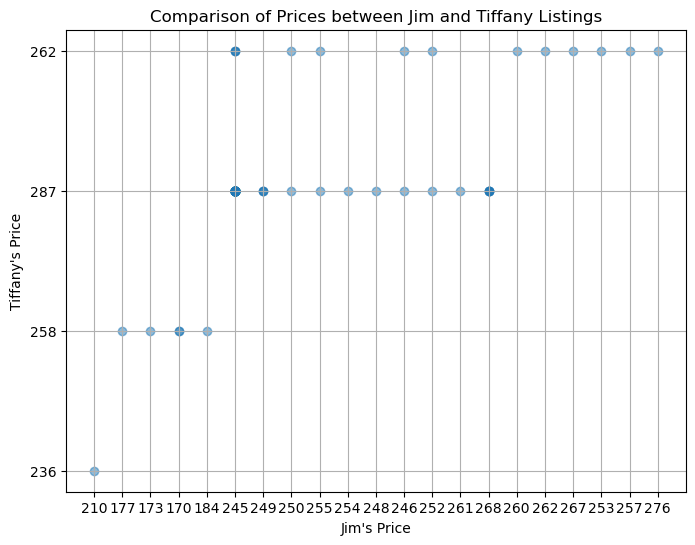

In [51]:
x_column = 'Jim Price in NZD'
y_column = 'Tiffany Price in NZD'

AirbnbData[x_column] = AirbnbData[x_column].astype(str)
AirbnbData[y_column] = AirbnbData[y_column].astype(str)

plt.figure(figsize=(8, 6))
plt.scatter(AirbnbData[x_column], AirbnbData[y_column], alpha=0.5)
plt.title(f'Comparison of Prices between Jim and Tiffany Listings')
plt.xlabel("Jim's Price")
plt.ylabel("Tiffany's Price")
plt.grid(True)
plt.show()

##### Jim & Michael

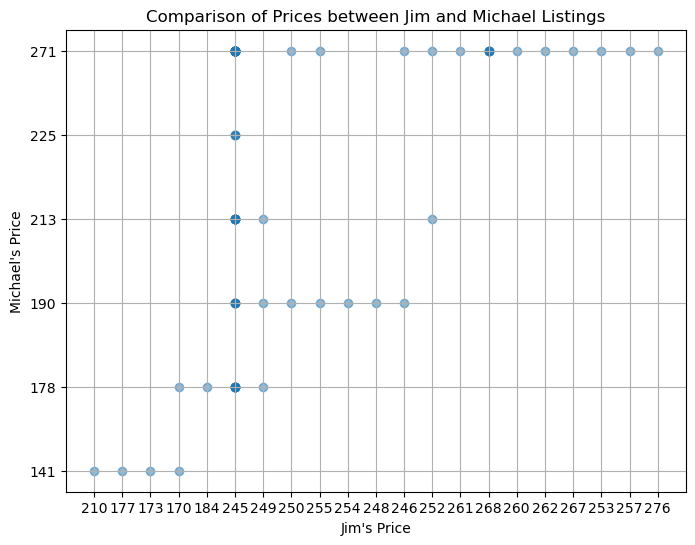

In [52]:
x_column = 'Jim Price in NZD'
y_column = 'Michael Price in NZD'

AirbnbData[x_column] = AirbnbData[x_column].astype(str)
AirbnbData[y_column] = AirbnbData[y_column].astype(str)

plt.figure(figsize=(8, 6))
plt.scatter(AirbnbData[x_column], AirbnbData[y_column], alpha=0.5)
plt.title(f'Comparison of Prices between Jim and Michael Listings')
plt.xlabel("Jim's Price")
plt.ylabel("Michael's Price")
plt.grid(True)
plt.show()

##### Jim & Noorani

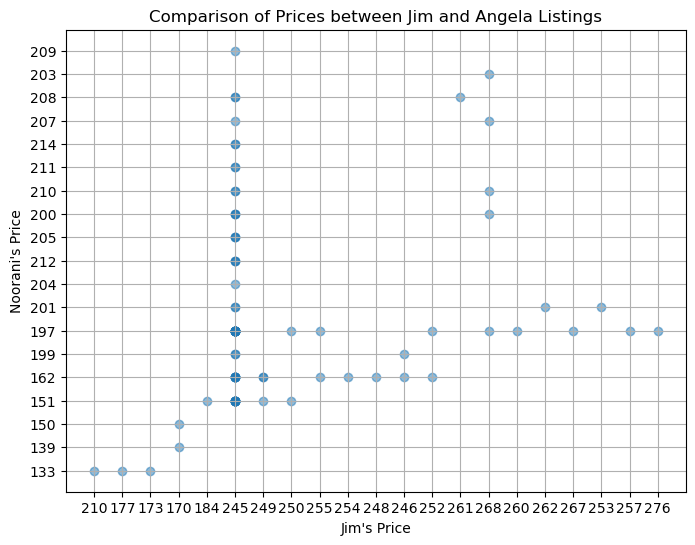

In [53]:
x_column = 'Jim Price in NZD'
y_column = 'Noorani Price in NZD'

AirbnbData[x_column] = AirbnbData[x_column].astype(str)
AirbnbData[y_column] = AirbnbData[y_column].astype(str)

plt.figure(figsize=(8, 6))
plt.scatter(AirbnbData[x_column], AirbnbData[y_column], alpha=0.5)
plt.title(f'Comparison of Prices between Jim and Angela Listings')
plt.xlabel("Jim's Price")
plt.ylabel("Noorani's Price")
plt.grid(True)
plt.show()

##### Jim & Andy

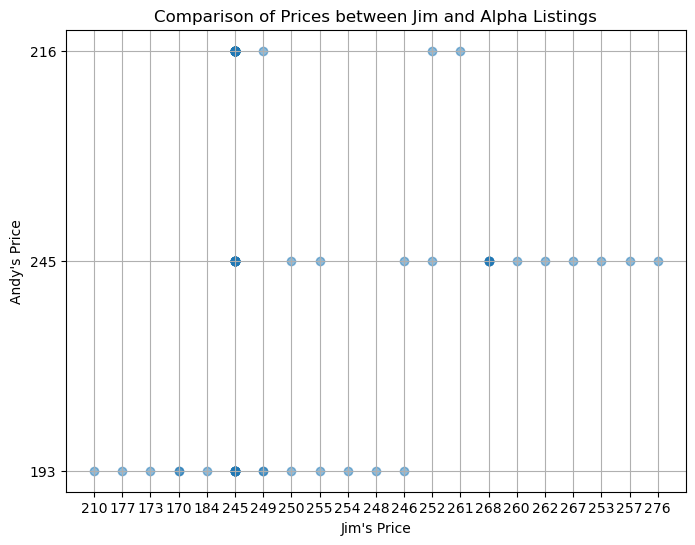

In [54]:
x_column = 'Jim Price in NZD'
y_column = 'Andy Price in NZD'

AirbnbData[x_column] = AirbnbData[x_column].astype(str)
AirbnbData[y_column] = AirbnbData[y_column].astype(str)

plt.figure(figsize=(8, 6))
plt.scatter(AirbnbData[x_column], AirbnbData[y_column], alpha=0.5)
plt.title(f'Comparison of Prices between Jim and Alpha Listings')
plt.xlabel("Jim's Price")
plt.ylabel("Andy's Price")
plt.grid(True)
plt.show()

##### Jim & Donghong

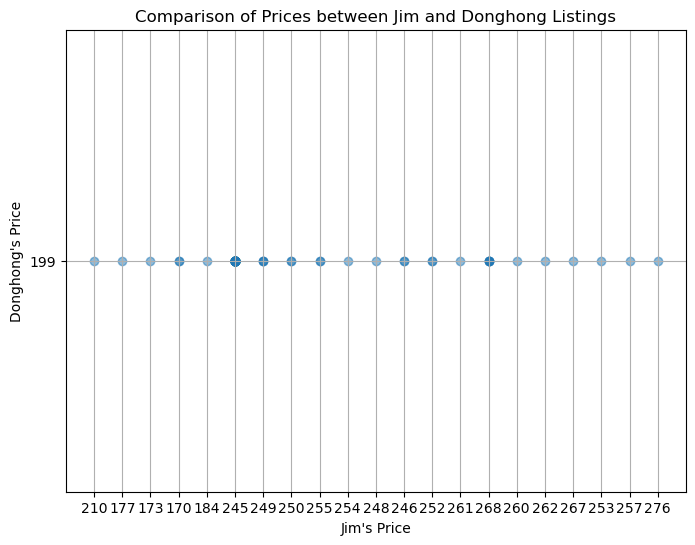

In [55]:
x_column = 'Jim Price in NZD'
y_column = 'Donghong Price in NZD'

AirbnbData[x_column] = AirbnbData[x_column].astype(str)
AirbnbData[y_column] = AirbnbData[y_column].astype(str)

plt.figure(figsize=(8, 6))
plt.scatter(AirbnbData[x_column], AirbnbData[y_column], alpha=0.5)
plt.title(f'Comparison of Prices between Jim and Donghong Listings')
plt.xlabel("Jim's Price")
plt.ylabel("Donghong's Price")
plt.grid(True)
plt.show()

#### Cosine Similarity


In [56]:
def cosine_similarity(x, y):
    # Convert input arrays to numeric values
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    
    dot_prod = np.dot(x, y)
    x_len = np.linalg.norm(x)
    y_len = np.linalg.norm(y)
    
    if x_len == 0 or y_len == 0:
        return 0  
    
    similarity = dot_prod / (x_len * y_len)
    return similarity

# Extract the price columns for saimilarity calculation
price_columns = [col for col in AirbnbData.columns if 'Price in NZD' in col]

# DataFrame with only the price columns
price_df = AirbnbData[price_columns]

# Calculate cosine similarity for each pair of listings
num_listings = len(price_columns)
similarity_matrix = np.zeros((num_listings, num_listings))

for i in range(num_listings):
    for j in range(num_listings):
        similarity_matrix[i, j] = cosine_similarity(price_df.iloc[:, i], price_df.iloc[:, j])

# Convert the similarity matrix into a DataFrame for better readability
similarity_df = pd.DataFrame(similarity_matrix, index=price_columns, columns=price_columns)

similarity_df

,Alex Price in NZD,Andy Price in NZD,Donghong Price in NZD,Glenda Price in NZD,Jim Price in NZD,Joshua Price in NZD,Michael Price in NZD,Noorani Price in NZD,Prince Price in NZD,Tiffany Price in NZD
Alex Price in NZD,1.000000,0.995236,0.998196,0.998196,0.998970,0.990556,0.988205,0.993731,0.998880,0.998647
Andy Price in NZD,0.995236,1.000000,0.995846,0.995846,0.996101,0.991528,0.991827,0.995112,0.996860,0.994432
Donghong Price in NZD,0.998196,0.995846,1.000000,1.000000,0.997077,0.985059,0.983965,0.991315,0.999057,0.999164
Glenda Price in NZD,0.998196,0.995846,1.000000,1.000000,0.997077,0.985059,0.983965,0.991315,0.999057,0.999164
Jim Price in NZD,0.998970,0.996101,0.997077,0.997077,1.000000,0.990500,0.988432,0.993336,0.997933,0.997582
Joshua Price in NZD,0.990556,0.991528,0.985059,0.985059,0.990500,1.000000,0.995174,0.994401,0.990003,0.984997
Michael Price in NZD,0.988205,0.991827,0.983965,0.983965,0.988432,0.995174,1.000000,0.997227,0.988873,0.983927
Noorani Price in NZD,0.993731,0.995112,0.991315,0.991315,0.993336,0.994401,0.997227,1.000000,0.994666,0.991333
Prince Price in NZD,0.998880,0.996860,0.999057,0.999057,0.997933,0.990003,0.988873,0.994666,1.000000,0.998660
Tiffany Price in NZD,0.998647,0.994432,0.999164,0.999164,0.997582,0.984997,0.983927,0.991333,0.998660,1.000000


#### Multi-Line Plot 


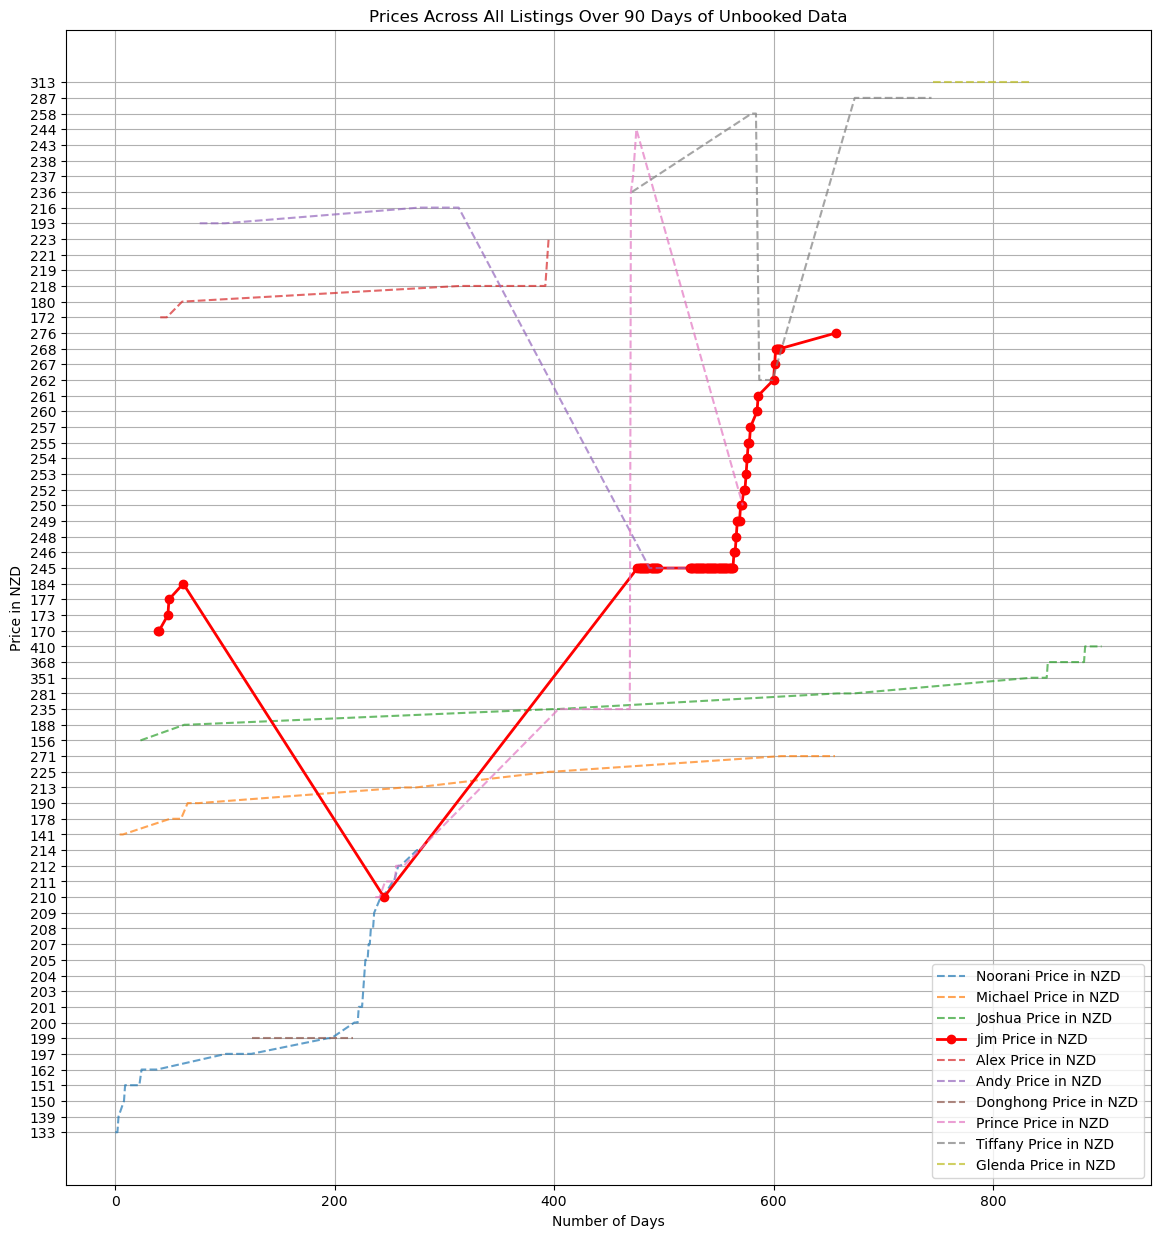

In [67]:
price_columns = [col for col in AirbnbData.columns if 'Price in NZD' in col]

#Price columns into a single DataFrame with listing names
all_prices = pd.DataFrame()
for col in price_columns:
    temp_df = AirbnbData[[col]].rename(columns={col: 'Price'})
    temp_df['Listing'] = col
    all_prices = pd.concat([all_prices, temp_df])

#Sort the prices
sorted_prices = all_prices.sort_values(by='Price').reset_index(drop=True)

#Plot
plt.figure(figsize=(14, 15))

#Plot prices for all listings
for listing in sorted_prices['Listing'].unique():
    if listing == 'Jim Price in NZD':
        plt.plot(
            sorted_prices[sorted_prices['Listing'] == listing].index,
            sorted_prices[sorted_prices['Listing'] == listing]['Price'],
            label=listing,
            marker='o',
            linewidth=2,
            color='red')
    else:
        plt.plot(
            sorted_prices[sorted_prices['Listing'] == listing].index,
            sorted_prices[sorted_prices['Listing'] == listing]['Price'],
            label=listing,
            linestyle='--',
            alpha=0.7)

plt.xlabel('Number of Days')
plt.ylabel('Price in NZD')
plt.title('Prices Across All Listings Over 90 Days of Unbooked Data')
plt.legend()
plt.grid(True)
plt.show()

#### Average Price Trend

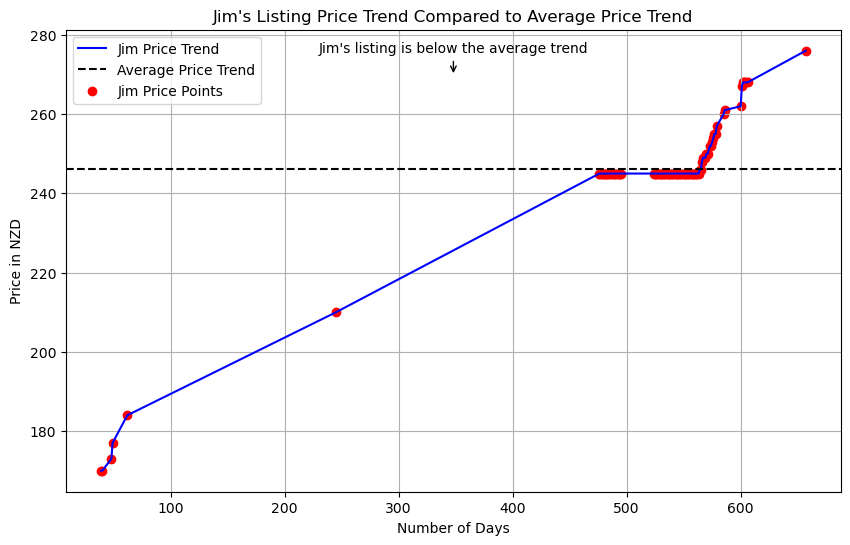

In [70]:
sorted_prices['Price'] = pd.to_numeric(sorted_prices['Price'], errors='coerce')

#Average price trend over the 90 days for all listings
average_price_trend = sorted_prices.groupby('Listing')['Price'].mean().reset_index()

#Average price trend across all listings
average_price_across_listings = average_price_trend['Price'].mean()

#Jim's listing price trend
jim_prices = sorted_prices[sorted_prices['Listing'] == 'Jim Price in NZD']['Price']

#Jim's listing price trend plot
plt.figure(figsize=(10, 6))
plt.plot(jim_prices, label='Jim Price Trend', color='blue')
plt.axhline(y=average_price_across_listings, color='black', linestyle='--', label='Average Price Trend')

#Jim's listing price points
plt.scatter(jim_prices.index, jim_prices, color='red', label='Jim Price Points')

#Annotation to indicate whether Jim's listing is above or below the average trend
if jim_prices.mean() > average_price_across_listings:
    annotation_text = 'Jim\'s listing is above the average trend'
else:
    annotation_text = 'Jim\'s listing is below the average trend'

plt.annotate(annotation_text,
             xy=(0.5, 0.9), xycoords='axes fraction',
             xytext=(0.5, 0.95), textcoords='axes fraction',
             horizontalalignment='center',
             arrowprops=dict(facecolor='black', arrowstyle='->'))

plt.xlabel('Number of Days')
plt.ylabel('Price in NZD')
plt.title('Jim\'s Listing Price Trend Compared to Average Price Trend')
plt.legend()
plt.grid(True)
plt.show()
